<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Digital Wage Payment Prediction</h1> 
<h2 style="text-align: center;" markdown="2">An AIMS Masters project in Collaboration with the Global Centre on Digital Wages for Decent Work (ILO)</h2>


> *The widespread adoption of digital payments has become increasingly important. In light of this, the aim of this project is to investigate the probability of an individual receiving digital wages in Africa. To achieve this, a series of empirical comparative assessments of machine learning classification algorithms will be conducted. The objective is to determine the effectiveness of these algorithms in predicting digital wage payments. Therefore, this notebook forms part of a larger project that seeks to explore the potential of machine learning in addressing issues related to financial inclusion in Africa.*

<h1 style="text-align: center;" markdown="3">Algorithm 3 - Random Forest Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Demographic Feature Set</h2>

# Table of Contents

[Introduction](#setup)  

[No Sample Weights](#noweights)

[Sample Weights](#weights)  

[Cross-Validation and Parameter Tuning](#cross-validation) 

[AdaBoost Random Forest Classifier](#ada-boost)

[Random Forest Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the Random Forest classifier to the dataset. 

As always, we start with loading our standard libraries and the data

In [1]:
%matplotlib inline

import os
import sys


import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

from sklearn.ensemble import RandomForestClassifier

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_data_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize


ALGORITHM_NAME = 'rf'
COUNTRY = 'dem_merged_dumvar'

TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)

# No Sample Weights <a class="anchor" id="noweights"></a>

Now let's apply the Random Forest classifier to the dataset with no weights.

In [2]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

CPU times: user 191 ms, sys: 3.16 ms, total: 195 ms
Wall time: 194 ms
CPU times: user 44.3 ms, sys: 231 µs, total: 44.5 ms
Wall time: 44.4 ms
In-sample score: 83.26%


/home/socrates/.local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


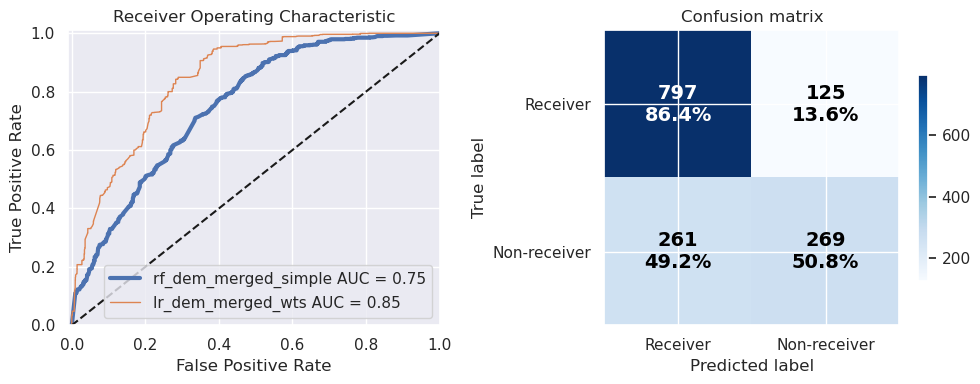

,rf_dem_merged_simple,lr_dem_merged_wts
accuracy,0.734160,0.809847
recall,0.864425,0.946640
precision,0.753308,0.782140
f1,0.805051,0.856563
cross_entropy,0.852455,0.450266
roc_auc,0.753430,0.845867
cohen_kappa,0.393434,0.469722


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 64.17% 


In [3]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = RandomForestClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models='lr_dem_merged_wts',
                                    store_model=True,
                                    model_name='dem_merged_simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

# Sample weights <a class="anchor" id="weights">

Next, we will incorporate the sample weights that came with the dataset, enabling us to generalize our model results to the overall population.

CPU times: user 158 ms, sys: 1.74 ms, total: 159 ms
Wall time: 159 ms
CPU times: user 38.8 ms, sys: 0 ns, total: 38.8 ms
Wall time: 38.5 ms
In-sample score: 84.30%


/home/socrates/.local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


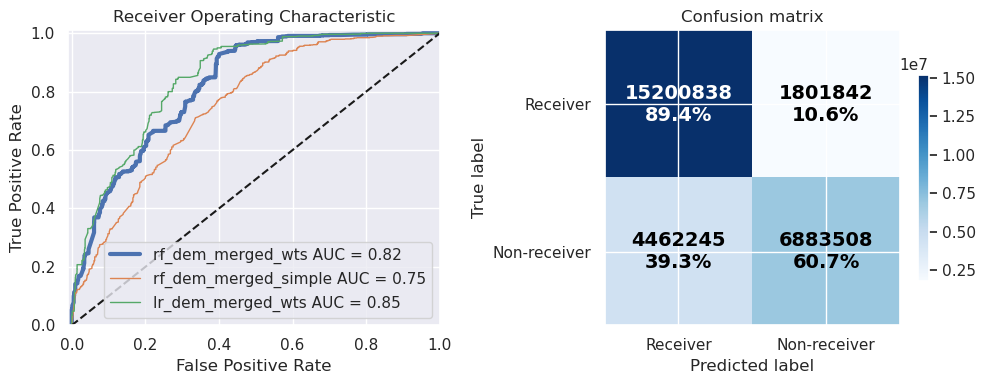

,rf_dem_merged_wts,rf_dem_merged_simple,lr_dem_merged_wts
accuracy,0.779032,0.734160,0.809847
recall,0.894026,0.864425,0.946640
precision,0.773065,0.753308,0.782140
f1,0.829157,0.805051,0.856563
cross_entropy,0.473915,0.852455,0.450266
roc_auc,0.821658,0.753430,0.845867
cohen_kappa,0.430798,0.393434,0.469722


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 67.87% 


In [4]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5, 
                               )
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_dem_merged_simple', 'lr_dem_merged_wts'],
                                    store_model=True,
                                    model_name='dem_merged_wts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Cross-validation and Parameter Tuning <a class="anchor" id="cross-validation"></a>

Now we do cross-validation when fitting the  model and try to find the best parameters through hyperparameter tuning.

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 631 ms, sys: 139 ms, total: 769 ms
Wall time: 5.03 s
In-sample score: 84.30%
Best model parameters: {'max_depth': 6, 'min_samples_leaf': 21, 'min_samples_split': 12, 'n_estimators': 100}


/home/socrates/.local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


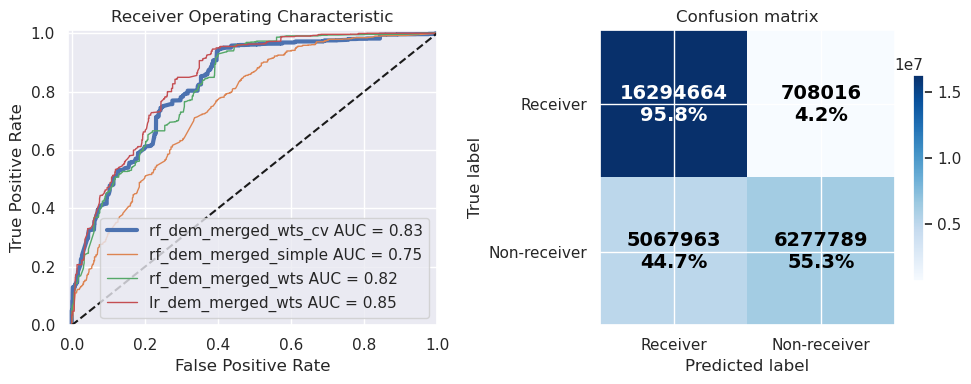

,rf_dem_merged_wts_cv,rf_dem_merged_simple,rf_dem_merged_wts,lr_dem_merged_wts
accuracy,0.796250,0.734160,0.779032,0.809847
recall,0.958359,0.864425,0.894026,0.946640
precision,0.762765,0.753308,0.773065,0.782140
f1,0.849448,0.805051,0.829157,0.856563
cross_entropy,0.476648,0.852455,0.473915,0.450266
roc_auc,0.825201,0.753430,0.821658,0.845867
cohen_kappa,0.452322,0.393434,0.430798,0.469722


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 73.71% 


In [5]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build the model
estimator = RandomForestClassifier()
parameters = {'n_estimators': [10, 50, 100, 150],
              'max_depth': np.arange(1,16,5), 
              'min_samples_split': np.arange(2,21,10),
              'min_samples_leaf': np.arange(1,46,20)
             }
model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
# %time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_dem_merged_simple', 
                                                    'rf_dem_merged_wts', 'lr_dem_merged_wts'],
                                    store_model=True,
                                    model_name='dem_merged_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)
best_model = model.best_estimator_

In [6]:
feat_imps.head(30)

,importance
account__1.0,0.610958
internetaccess__2.0,0.121071
fin33__2.0,0.090455
educ__2.0,0.038661
mobileowner__2.0,0.029952
inc_q__5.0,0.025482
age__1,0.016897
educ__3.0,0.012539
inc_q__2.0,0.009226
urbanicity_f2f__2.0,0.008810


# AdaBoost Random Forest Classifier <a class="anchor" id="ada-boost"></a>

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 8.04 s, sys: 0 ns, total: 8.04 s
Wall time: 27.5 s
CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.32 s
In-sample score: 78.66%
Best model parameters: {'learning_rate': 0.01, 'n_estimators': 50}


/home/socrates/.local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


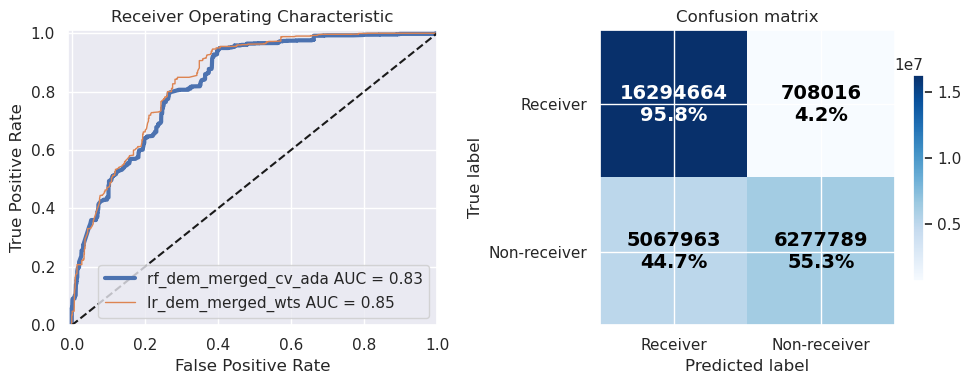

,rf_dem_merged_cv_ada,lr_dem_merged_wts
accuracy,0.796250,0.809847
recall,0.958359,0.946640
precision,0.762765,0.782140
f1,0.849448,0.856563
cross_entropy,0.479117,0.450266
roc_auc,0.832922,0.845867
cohen_kappa,0.452322,0.469722


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 73.44% 


In [7]:
from sklearn.ensemble import AdaBoostClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build the model
estimator = AdaBoostClassifier(best_model)

parameters = {'n_estimators': [50, 100], 
              'learning_rate': [0.01, 0.1]
             }
model = GridSearchCV(estimator, parameters, verbose=3, cv=3, n_jobs=-1)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models = 'lr_dem_merged_wts',
#                                     compare_models=['lr_dem_merged_wts', 'rf_dem_merged_simple', 
#                                                                   'rf_dem_merged_wts'],
                                    store_model=True,
                                    model_name='dem_merged_cv_ada', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)
best_model = model.best_estimator_

In [8]:
feat_imps.head(30)

,importance
account__1.0,0.605828
internetaccess__2.0,0.090787
fin33__2.0,0.090096
educ__2.0,0.041376
mobileowner__2.0,0.029586
inc_q__5.0,0.025081
age__1,0.024131
educ__3.0,0.020141
urbanicity_f2f__2.0,0.013173
female__2.0,0.012666


# Random Forest Summary <a class="anchor" id="summary"></a>

We have covered the basic concepts of a Random Forest classifier, and applied it to our dataset. We also explored some techniques for analyzing the performance of our model as well as tuning parameters.

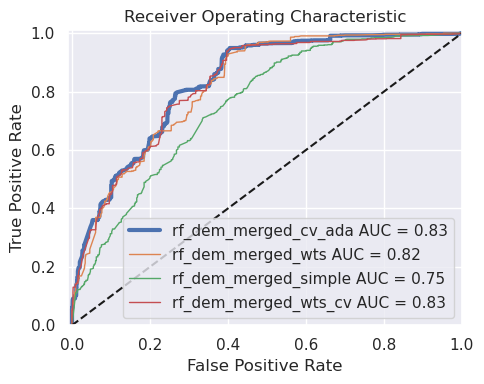

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa
rf_dem_merged_cv_ada,0.796250,0.958359,0.762765,0.849448,0.479117,0.832922,0.452322
rf_dem_merged_wts,0.779032,0.894026,0.773065,0.829157,0.473915,0.821658,0.430798
rf_dem_merged_simple,0.734160,0.864425,0.753308,0.805051,0.852455,0.753430,0.393434
rf_dem_merged_wts_cv,0.796250,0.958359,0.762765,0.849448,0.476648,0.825201,0.452322


In [9]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)